# Fourier Transform Modelling development
> A script for developing the functions needed to model the optical systems with Fourier Transforms and complex array phase pupils

In [1]:
import numpy as np
from scipy.fftpack import fft2, fftshift
from tqdm import tqdm
import matplotlib.pyplot as plt
from formatter import *
import os
from conversions import *

In [2]:
os.chdir("..")
print(os.getcwd())
from FT_modelling import pupil_phase_offset_test

/Users/louis/Projects/Toliman/Modelling


To Do:
- Turn model_FT_broadband into simple loop that calls model_FT_monochromatic

## Current scripts

In [3]:
def model_FT(mask, mask_size, chip_dim, wavel, foc_length, pix_size):
    """
    Inputs:
        mask: Phase mask complex array 
        mask_size: Size of the phase mask, ie the aperture diameter (m)
        chip dim: Units of num pixels
        wavel: Wavelength (m)
        foc_lenght: Focal length of lens/distance to focal plane of telescope (m)
        pix_size: Detector pitch, size of pixel unit cell (m)
    """
    grid_size = mask.shape[1]
    plate_scale = pix_size / foc_length    # Radians per pixel
    
    spatial_freq = wavel/mask_size
    array_size = int(grid_size*spatial_freq/plate_scale)
    complex_array = np.zeros((array_size,array_size),dtype=complex)
    complex_array[0:grid_size, 0:grid_size] = mask
    im = np.fft.fftshift(np.abs(np.fft.fft2(complex_array))**2)
#     im = fftshift(np.abs(fft2(complex_array))**2)
        
    # Note: This could intorduce some form of float error (ie returns a 9x9 instead of 10x10 array)
    start = (array_size-chip_dim)//2
    end = array_size - (array_size-chip_dim)//2
    im_out = im[start:end, start:end]

    return im_out



In [4]:
def model_FT_broadband(mask, mask_size, chip_dim, wavels, weights, foc_length, pix_size):
    """
    Inputs:
        mask: Phase mask complex array 
        mask_size: Size of the phase mask, ie the aperture diameter (m)
        chip dim: Units of num pixels
        wavels: Array of wavelengths (m)
        weights: Relative weights of each wavelength
        foc_lenght: Focal length of lens/distance to focal plane of telescope (m)
        pix_size: Detector pitch, size of pixel unit cell (m)
        
    Note:
        Untested
    """
    im_out = np.zeros((chip_dim,chip_dim))
    
    for wavel, weight in zip(wavels, weights):
        im_out += weight * model_FT(mask, mask_size, chip_dim, wavel, foc_length, pix_size)

    return im_out

In [125]:
def pupil_phase_offset(pupil, aperture, wavelength, azimuthal_offset, angular_offset, shift=False):
    """
    Calculates the change in phase across the pupil induced by an off centre star
    pupil: complex array representing the phase pupil
    aperture: Aperture of the telescope (m)
    wavelength: Wavelength to be modelled (m)
    azimuthal_offset: Angle that is formed between the star being modelled and the normal of the telesope aperture (arcseconds)
    angular_offset: Angle around the circle formed by azimulath offset, 0 = offset in +x, pi/2 = offest in +y etc (radians)
    """
    # Calcuate the needed  values
    gridsize = pupil.shape[0]
    phi = arcsec_to_rad(azimuthal_offset)
    OPD = aperture*np.tan(phi)
    cycles = OPD/wavelength
    period = gridsize/cycles

    # Calculate the phase change over the pupil
#     Xs = np.linspace(0,gridsize-1, num=gridsize)
    Xs = np.linspace(-gridsize//2,(gridsize//2)-1, num=gridsize)
    X, Y = np.meshgrid(Xs, Xs)
    r = np.hypot(X, Y)
    theta = np.arctan2(X, Y) - angular_offset 
    y_new = r * np.sin(theta)
    
    if shift:
        phase_shift = period/2
    else:
        phase_shift = period
    
    y_new += phase_shift
    
    eta = y_new * 2*np.pi/period
#     eta_mod = eta%(2*np.pi)
#     eta[eta_mod < np.pi/2] = -eta[eta_mod < np.pi/2]
#     eta[eta_mod > 3*np.pi/2] = -eta[eta_mod > 3*np.pi/2]
#     phase_array = np.sin(eta)*np.pi
    phase_array = eta
    
    return phase_array
    
    
'''
#     phase_shift = shift * 2*np.pi/period
#     shift = period/4

    eta = y_new * 2*np.pi/period
    
#     eta_mod = eta%(2*np.pi) - np.pi # Added -np.pi
    eta_mod = eta%(2*np.pi)
    
#     eta[eta_mod < np.pi] = -eta[eta_mod < np.pi]
    eta[eta_mod < (np.pi/2)] = -eta[eta_mod < (np.pi/2)]
    eta[eta_mod > (3*np.pi/2)] = -eta[eta_mod > (3*np.pi/2)]

    phase_array = np.sin(eta)*np.pi
    
    return phase_array
    
    anti_phase_array = np.sin(eta+np.pi/2)*np.pi
    
    
    mask = np.angle(pupil) > 0
    inv_mask = -(mask - 1)
    
    selection1 = np.multiply(phase_array, mask)
    selection2 = np.multiply(anti_phase_array, inv_mask)
    
    return selection1, selection2

    pupil_phase = selection1 + selection2
    
    
    
    
    
    
    # Impose the phase array on to the pupil
    mag_array = np.abs(pupil)
#     angle_array = np.angle(pupil)
    
    aperture_phase = mag_array * (phase_array + angle_array)%2*np.pi
    pupil_out = mag_array * np.exp(1j*pupil_phase)
    
    return pupil_out
    '''

'\n#     phase_shift = shift * 2*np.pi/period\n#     shift = period/4\n\n    eta = y_new * 2*np.pi/period\n    \n#     eta_mod = eta%(2*np.pi) - np.pi # Added -np.pi\n    eta_mod = eta%(2*np.pi)\n    \n#     eta[eta_mod < np.pi] = -eta[eta_mod < np.pi]\n    eta[eta_mod < (np.pi/2)] = -eta[eta_mod < (np.pi/2)]\n    eta[eta_mod > (3*np.pi/2)] = -eta[eta_mod > (3*np.pi/2)]\n\n    phase_array = np.sin(eta)*np.pi\n    \n    return phase_array\n    \n    anti_phase_array = np.sin(eta+np.pi/2)*np.pi\n    \n    \n    mask = np.angle(pupil) > 0\n    inv_mask = -(mask - 1)\n    \n    selection1 = np.multiply(phase_array, mask)\n    selection2 = np.multiply(anti_phase_array, inv_mask)\n    \n    return selection1, selection2\n\n    pupil_phase = selection1 + selection2\n    \n    \n    \n    \n    \n    \n    # Impose the phase array on to the pupil\n    mag_array = np.abs(pupil)\n#     angle_array = np.angle(pupil)\n    \n    aperture_phase = mag_array * (phase_array + angle_array)%2*np.pi\n    

In [126]:
def phase_driver(pupil, aperture, wavelength, azimuthal_offset, angular_offset):
    """
    Calculates the change in phase across the pupil induced by an off centre star
    pupil: complex array representing the phase pupil
    aperture: Aperture of the telescope (m)
    wavelength: Wavelength to be modelled (m)
    azimuthal_offset: Angle that is formed between the star being modelled and the normal of the telesope aperture (arcseconds)
    angular_offset: Angle around the circle formed by azimulath offset, 0 = offset in +x, pi/2 = offest in +y etc (radians)
    """
    if azimuthal_offset == 0:
        return pupil
    
    phase = pupil_phase_offset(pupil, aperture, wavelength, azimuthal_offset, angular_offset, shift=False)
    anti_phase = pupil_phase_offset(pupil, aperture, wavelength, azimuthal_offset, angular_offset, shift=True)
    
    mag_array = np.abs(pupil)

    mask = np.angle(pupil) > 0
    

    inv_mask = -(mask - 1)
    
    selection1 = np.multiply(phase, inv_mask)
    selection2 = np.multiply(anti_phase, mask)
    
    selection = selection1 + selection2
    
    aperture_phase = mag_array * selection
    
    # ------
    new_pupil = mag_array * np.exp(1j*aperture_phase)
    
#     aperture_phase1 = mag_array * selection1
#     selection1 = mag_array * np.exp(1j*aperture_phase1)
    
#     aperture_phase2 = mag_array * selection2
#     selection2 = mag_array * np.exp(1j*aperture_phase2)
    
    return new_pupil, phase, anti_phase #selection1, selection2 

In [127]:
# test AREA

In [128]:
# theta = 0
# new_pupil, phase, anti_phase = phase_driver(pupil, aperture, wavelength, azimuthal_offset, theta)
# old_pupil, old_phase = pupil_phase_offset_test(pupil, aperture, wavelength, azimuthal_offset, theta)

# plt.figure(figsize = (10, 5))
# plt.subplot(1, 2, 1)
# plt.imshow(np.angle(new_pupil))
# plt.colorbar()
# plt.subplot(1, 2, 2)
# plt.imshow(np.angle(old_pupil))
# plt.colorbar()
# plt.show()

In [129]:
# theta = 0
# new_pupil, phase, anti_phase = phase_driver(pupil, aperture, wavelength, azimuthal_offset, theta)
# old_pupil, old_phase = pupil_phase_offset_test(pupil, aperture, wavelength, azimuthal_offset, theta)

# # plt.figure(figsize = (10, 5))
# # plt.subplot(1, 2, 1)
# # plt.plot(np.angle(new_pupil)[1000, :])
# # # plt.colorbar()
# # plt.subplot(1, 2, 2)
# # plt.plot(np.angle(old_pupil)[1000, :])
# # # plt.colorbar()
# # plt.show()


# plt.figure(figsize = (10, 5))
# plt.subplot(1, 1, 1)
# plt.plot(np.angle(new_pupil)[1000, :])
# # plt.plot(np.angle(old_pupil)[1000, 550:])
# # plt.colorbar()
# plt.show()

## Development Area

In [130]:
wavelength  = 500e-9
aperture = 0.02 # m
focal_length = 0.15 # m

# CCD Architecture
detector_size = 256
detector_pitch = 1.12e-6

# azimuthal_offset = 16.5
azimuthal_offset = 16.5*2
angular_offset = 0 #np.pi/3

In [131]:
pupil = pupil_from_fits("files/pupil_new_2k.fits")

In [132]:
# plt.imshow(np.angle(pupil))
# plt.colorbar()

In [134]:
s = []
old = []
num = 16
thetas = np.linspace(-np.pi, np.pi*(1-(1/num)), num=num)
for theta in tqdm(thetas):
    selection, s1, s2 = phase_driver(pupil, aperture, wavelength, azimuthal_offset, theta)
    old_mask, old_phase = pupil_phase_offset_test(pupil, aperture, wavelength, azimuthal_offset, theta)
    old.append(old_phase)
    s.append((selection, s1, s2, np.add(s1,s2)))


In [135]:
%%time
ims = []
for p in tqdm(s):
    im = model_FT(p[0], aperture, detector_size, wavelength, focal_length, detector_pitch)
    ims.append(im)

100%|██████████| 16/16 [01:01<00:00,  3.41s/it]

CPU times: user 1min 4s, sys: 22.8 s, total: 1min 27s
Wall time: 1min 1s


100%|██████████| 16/16 [00:01<00:00, 10.55it/s]


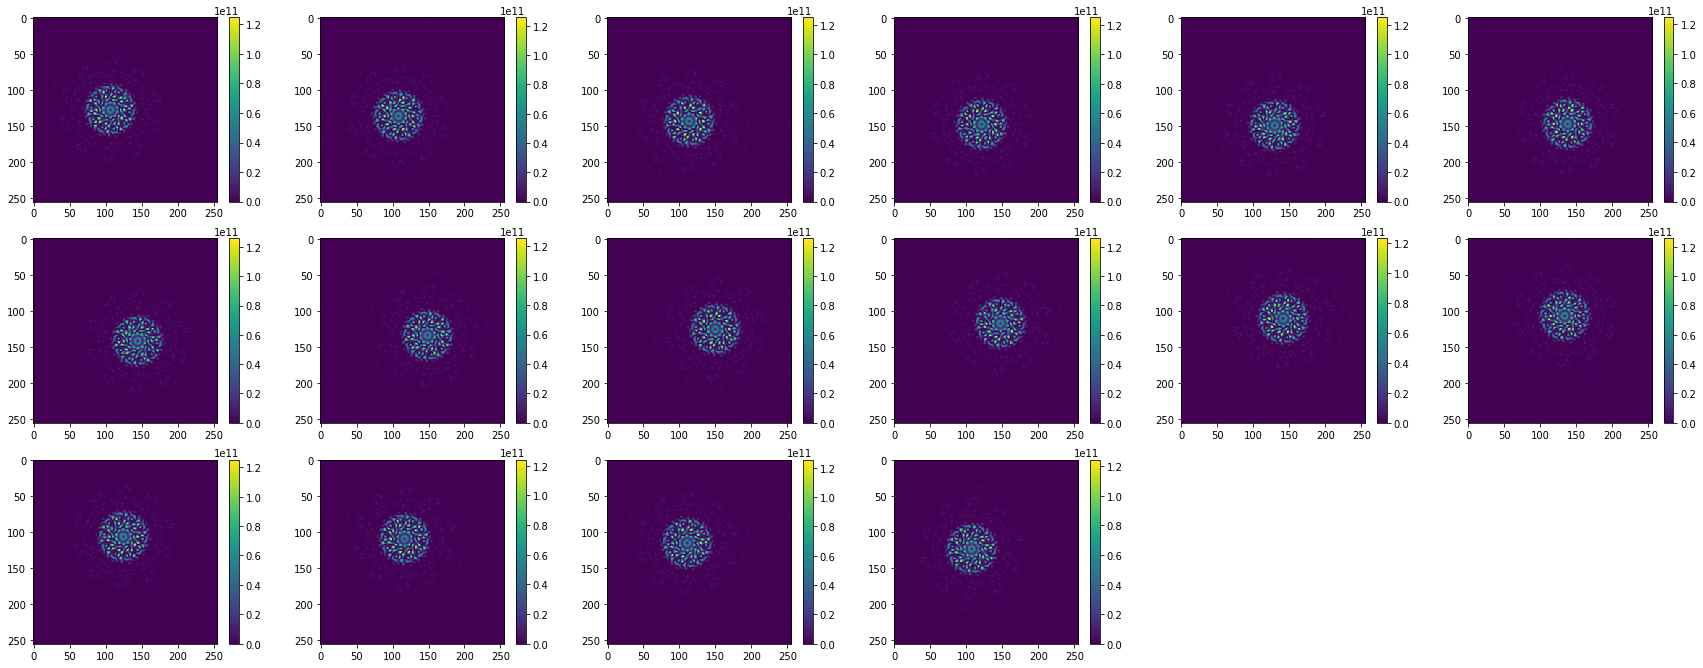

In [136]:
plt.figure(figsize = (30, 40))

for i in tqdm(range(len(ims))):
    plt.subplot(10, 6, i + 1)
#     plt.imshow(np.log(ims[i]))
    plt.imshow(ims[i])
    plt.colorbar()

plt.show()

In [106]:
# mask = np.angle(pupil) > 0
# inv_mask = -(mask - 1)
# phase = np.angle(pupil_phases_offset[0])
# phase2 = np.angle(pupil_phases_offset[4])

# plt.figure(figsize = (20, 10))

# plt.subplot(2, 3, 1)
# plt.imshow(np.angle(pupil))

# plt.subplot(2, 3, 2)
# plt.imshow(phase)
# selection1 = np.multiply(phase, mask)
# plt.subplot(2, 3, 3)
# plt.imshow(selection1)

# plt.subplot(2, 3, 5)
# plt.imshow(phase2)
# plt.subplot(2, 3, 6)
# selection2 = np.multiply(phase2, inv_mask)
# plt.imshow(selection2)

# plt.subplot(2, 3, 4)
# plt.imshow(selection1 + selection2)


# plt.show()

# print(type(selection1 + selection2))

In [138]:
create_gif(ims, "asymmetry_test")

In [436]:
# empty_pupil = np.zeros([1000, 1000], dtype=complex)

# c = 500

# for i in range(1000):
#     for j in range(1000):
#         x = i - c
#         y = j - c 
#         r = np.hypot(x, y)
#         if r > c:
#             empty_pupil[i][j] = np.complex(0, 0)
#         else:
#             empty_pupil[i][j] = -np.complex(1, 0)

## Redundant scripts

In [12]:
# Non vectorised slow version of current scripts

def model_FT_old(mask, mask_size, chip_dim, wavels, foc_length, pix_size):
    """
    Redundant version, much slower use model_FT_monochromatic/broadband
    
    Inputs:
        mask: Phase mask complex array 
        mask_size: Size of the phase mask, ie the aperture diameter (m)
        chip dim: Units of num pixels
        wavels: Array of wavelengths (m)
        foc_lenght: Focal length of lens/distance to focal plane of telescope (m)
        pix_size: Detector pitch, size of pixel unit cell (m)
    Note: Assumes all wavelengths have equal intesity (add intesities later)
    """
    grid_size = mask.shape[1]
    plate_scale = pix_size / foc_length    # Radians per pixel
    
    im_out = np.zeros((chip_dim,chip_dim))

    for wavel in wavels:
        spatial_freq = wavel/mask_size
        array_size = int(grid_size*spatial_freq/plate_scale)
        complex_array = np.array(np.zeros((array_size,array_size)),dtype=complex)
        complex_array[0:grid_size,0:grid_size] = mask
        im = np.fft.fftshift(np.abs(np.fft.fft2(complex_array))**2)
            
        # Vector or matrix operation
        # Scipy or numpy regridding
        for y in range(chip_dim):
            for x in range(chip_dim):
                # Split line below and multiply line below by some scale/ratio to normalise
                # Pass in all wavelengths across all bands together and sum then normalise to 1
                im_out[y][x] += im[int((array_size-chip_dim)/2) + y][int((array_size-chip_dim)/2) + x]

    return im_out

In [4]:
# Non vectorised slow version

def pupil_phase_offset_old(pupil, aperture, wavelength, azimuthal_offset, angular_offset):
    """
    Redundant, faster vectorised version as pupil_phase_offset
    
    Calculates the change in phase across the pupil induced by an off centre star
    pupil: complex array representing the phase pupil
    aperture: Aperture of the telescope (m)
    wavelength: Wavelength to be modelled (m)
    azimuthal_offset: Angle that is formed between the star being modelled and the normal of the telesope aperture (arcseconds)
    angular_offset: Angle around the circle formed by azimulath offset, 0 = offset in +x, pi/2 = offest in +y etc (radians)
    """
    gridsize = pupil.shape[0]
    offset = asec_to_rad(azimuthal_offset)
    OPD = aperture*np.tan(offset)
    cycles = OPD/wavelength
    period = gridsize/cycles
    phase_array = np.zeros([gridsize, gridsize])
    
    for x in range(gridsize):
        for y in range(gridsize):

            # Shift the coordinates to get an off axis sine wave
            r = np.hypot(x, y)
            theta = np.arctan2(y, x) - angular_offset
            y_new = r*np.sin(theta)

            # Calcualte the sine wave input value in the new coordiante system
            eta = y_new * 2*np.pi/period

            # Try changing seocnd if statement to no remainder
            if eta%(2*np.pi) < np.pi/2 or eta%(2*np.pi) >= 3*np.pi/2:
                phase_array[x][y] = np.sin(eta)*np.pi
            else:
                phase_array[x][y] = -np.sin(eta)*np.pi
                
    pupil_out = np.zeros([gridsize, gridsize], dtype=complex)
    for i in range(gridsize):
        for j in range(gridsize):
            mag = np.abs(pupil[i][j])

            if mag == 0:
                pupil_out[i][j] = np.complex(0,0)

            else:
                angle = phase_array[i][j] - np.angle(pupil[i][j]) 
                pupil_out[i][j] = mag*np.exp(1j*angle)
                
    return pupil_out